In [106]:
import os 
from pathlib import Path 
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [146]:
p = Path("./Dataset1/")

dirs = p.glob("*")

image_data = []
labels = []
image_paths = []
label_dict = {"Arcanine":0,"Squirtle":1,"Pikachu":2,"Raichu":3,"Bulbasaur":4}
label2pokemon = {0:"Arcanine",1:"Squirtle",2:"Pikachu",3:"Raichu",4:"Bulbasaur"} #Reverse mapping

for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1]
    
    cnt = 0
    print(label)
    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(40,40))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        
        labels.append(label_dict[label])
        cnt += 1
    
    print(cnt)

.DS_Store
0
Arcanine
61
Squirtle
186
Pikachu
199
Raichu
71
Bulbasaur
174


### Visualisation

In [108]:
import numpy as np

In [109]:
print(len(labels))

691


In [156]:
x = np.array(image_data)
y = np.array(labels)

print(x.shape)
print(y.shape)

(691, 40, 40, 3)
(691,)


In [157]:
from sklearn.utils import shuffle
x,y = shuffle(x,y,random_state=2)

x = x/255.0

In [120]:
def drawing(img,label):
    plt.imshow(img)
    plt.title(label2pokemon[label])
    plt.grid(False)
    plt.style.use('seaborn')
    plt.axis('off')
    plt.show()

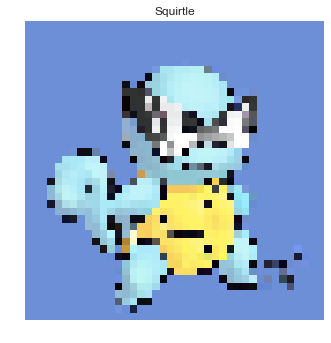

In [149]:
drawing(x[-1],y[-1])

In [150]:
print(x.shape)

(691, 40, 40, 3)


In [158]:
from sklearn.model_selection import train_test_split
x,x_,y,y_ = train_test_split(x,y,test_size=0.2,random_state=42)

In [159]:
print(x.shape)
print(y.shape)
print(x_.shape)
print(y_.shape)

(552, 40, 40, 3)
(552,)
(139, 40, 40, 3)
(139,)


### Neural Network:

In [140]:
def softmax(a):
    ea = np.exp(a) #returns a vector
    ans = ea/np.sum(ea,axis=1,keepdims=True)
    return ans

In [171]:
class NeuralNetwork:
    
    def __init__(self,input_size,layers,output_size):
        np.random.seed(0)
        
        model = {}
        
        #First Layers
        model['w1'] = np.random.randn(input_size,layers[0]) #creates a 3*4 matrix
        model['b1'] = np.zeros((1,layers[0]))
        
        #Second Layer
        model['w2'] = np.random.randn(layers[0],layers[1]) #creates a 4*3 matrix
        model['b2'] = np.zeros((1,layers[1]))
        
        #Third Layer
        model['w3'] = np.random.randn(layers[1],output_size) #creates a 3*2 matrix
        model['b3'] = np.zeros((1,output_size))
        
        self.model = model
        self.activation_outputs = None
        
    def forward(self,x):
        
        w1,w2,w3 = self.model['w1'], self.model['w2'], self.model['w3']
        b1,b2,b3 = self.model['b1'], self.model['b2'], self.model['b3']
        
        z1 = np.dot(x,w1) + b1
        a1 = np.tanh(z1) #tanh reduces the range in -1 to 1, like sigmoid does from 0 to 1
        
        z2 = np.dot(a1,w2) + b2
        a2 = np.tanh(z2) 
        
        z3 = np.dot(a2,w3) + b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
        
    def backward(self,x,y,learning_rate=0.001):
        W1,W2,W3 = self.model['w1'],self.model['w2'],self.model['w3']
        b1, b2, b3 = self.model['b1'],self.model['b2'],self.model['b3']
        m = x.shape[0]
        
        a1,a2,y_ = self.activation_outputs
        
        delta3 = y_ - y
        dw3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis=0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3,W3.T)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2,W2.T)
        dw1 = np.dot(x.T,delta1)
        db1 = np.sum(delta1,axis=0)
        
        
        #Update the Model Parameters using Gradient Descent
        self.model["w1"]  -= learning_rate*dw1
        self.model['b1']  -= learning_rate*db1
        
        self.model["w2"]  -= learning_rate*dw2
        self.model['b2']  -= learning_rate*db2
        
        self.model["w3"]  -= learning_rate*dw3
        self.model['b3']  -= learning_rate*db3
        
    
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis = 1)
    
    def summary(self):
        w1,w2,w3 = self.model['w1'], self.model['w2'], self.model['w3']
        b1,b2,b3 = self.model['b1'], self.model['b2'], self.model['b3']
        
        a1,a2,y_ = self.activation_outputs
        
        print('W1 ',w1.shape)
        print('A1 ',a1.shape)
        
        print('W2 ',w2.shape)
        print('A2 ',a2.shape)
        
        print('W3 ',w3.shape)
        print('Y_ ',y_.shape)

In [142]:
def loss(y_oht,p):
    l = -np.mean(y_oht*np.log(p))
    return l

In [143]:
def one_hot(y,depth):
    m = y.shape[0]
    y_oht = np.zeros((m,depth))
    y_oht[np.arange(m),y] = 1
        
    return y_oht

In [162]:
def train(x,y,model,epochs,lr,logs=True):
    training_loss = []
    classes = 5
    y_oht = one_hot(y,classes)
    
    for ix in range(epochs):
        y_ = model.forward(x)
        l = loss(y_oht,y_)
        training_loss.append(l)
        model.backward(x,y_oht,lr)
        if(logs):
            if(ix%50==0):
                print("Epoch %d Loss %.4f"%(ix,l))
            
    return training_loss

In [176]:
def accuracy(x,y):
    outputs = model.predict(x)
    acc = np.sum(outputs==y)/y.shape[0]
    return acc

In [172]:
model = NeuralNetwork(input_size=4800,layers=[100,50],output_size=5)

In [160]:
x = x.reshape(x.shape[0],-1)
print(x.shape)

x_ = x_.reshape(x_.shape[0],-1)
print(x_.shape)

(552, 4800)
(139, 4800)


In [173]:
l = train(x,y,model,500,0.0002)

Epoch 0 Loss 2.3985
Epoch 50 Loss 0.2644
Epoch 100 Loss 0.1818
Epoch 150 Loss 0.1313
Epoch 200 Loss 0.1103
Epoch 250 Loss 0.0975
Epoch 300 Loss 0.1170
Epoch 350 Loss 0.0761
Epoch 400 Loss 0.0693
Epoch 450 Loss 0.0625


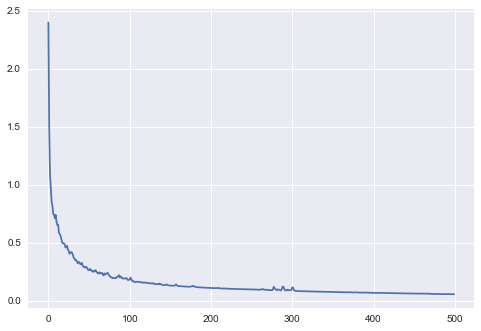

In [175]:
plt.plot(l)
plt.show()

In [177]:
acc_train = accuracy(x,y)
acc_test = accuracy(x_,y_)
print(acc_train)
print(acc_test)

0.9130434782608695
0.37410071942446044


### Analysing our predictions:

In [183]:
from sklearn.metrics import confusion_matrix,classification_report
from visualize1 import plot_confusion_matrix

In [179]:
outputs = model.predict(x)
train_matrix = confusion_matrix(y,outputs)


Confusion matrix, without normalization
[[ 43   4   3   1   2]
 [  2 144   5   0   5]
 [  0   3 145   2   2]
 [  1   6   1  45   1]
 [  0   9   0   1 127]]


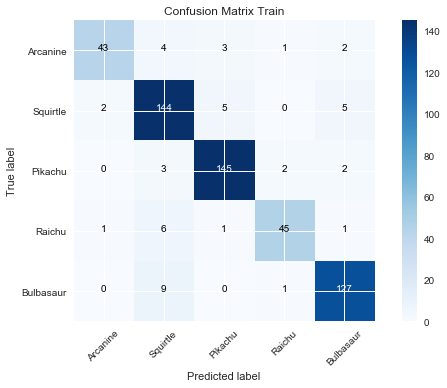

In [180]:
plot_confusion_matrix(train_matrix,classes=["Arcanine","Squirtle","Pikachu","Raichu","Bulbasaur"],title="Confusion Matrix Train")

In [181]:
test_outputs = model.predict(x_)
test_matrix = confusion_matrix(y_,test_outputs)

Confusion matrix, without normalization
[[ 1  1  4  2  0]
 [ 2 14  6  1  7]
 [ 7  7 19  7  7]
 [ 0  3  6  5  3]
 [ 1 13  8  2 13]]


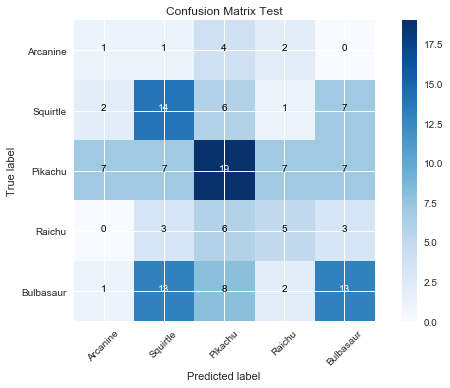

In [182]:
plot_confusion_matrix(test_matrix,classes=["Arcanine","Squirtle","Pikachu","Raichu","Bulbasaur"],title="Confusion Matrix Test")

In [187]:
print(classification_report(y,outputs))

             precision    recall  f1-score   support

          0       0.93      0.81      0.87        53
          1       0.87      0.92      0.89       156
          2       0.94      0.95      0.95       152
          3       0.92      0.83      0.87        54
          4       0.93      0.93      0.93       137

avg / total       0.91      0.91      0.91       552



In [188]:
print(classification_report(y_,test_outputs))

             precision    recall  f1-score   support

          0       0.09      0.12      0.11         8
          1       0.37      0.47      0.41        30
          2       0.44      0.40      0.42        47
          3       0.29      0.29      0.29        17
          4       0.43      0.35      0.39        37

avg / total       0.39      0.37      0.38       139



In [189]:
outputs.shape

(552,)

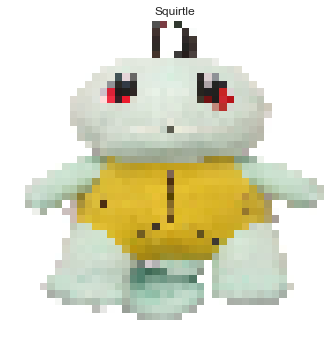

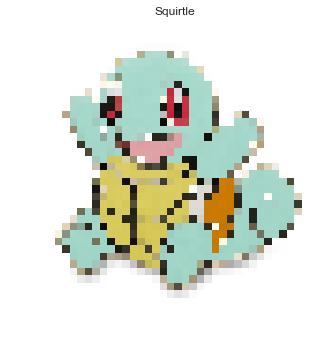

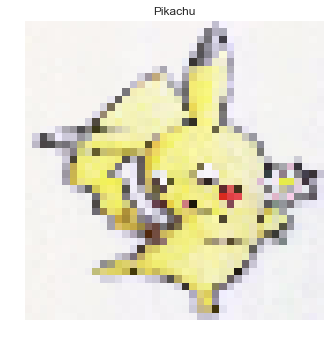

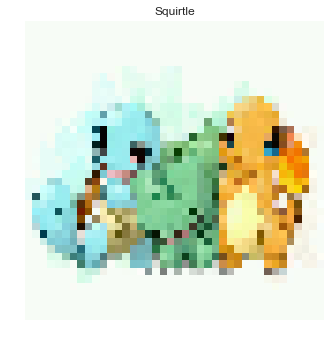

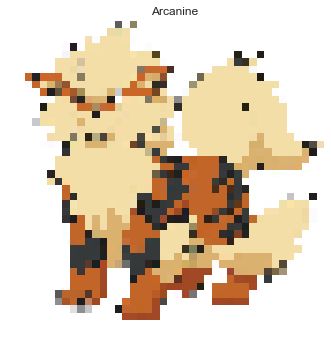

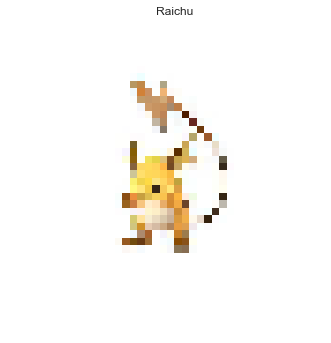

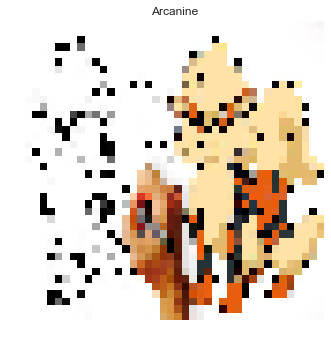

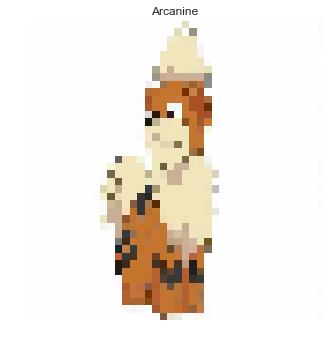

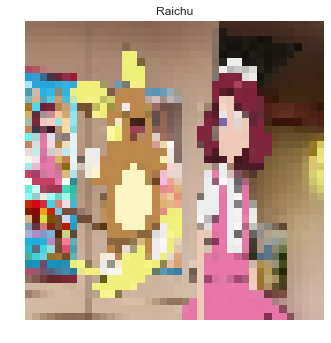

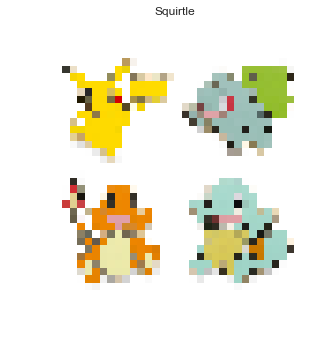

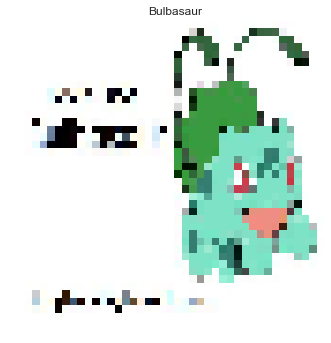

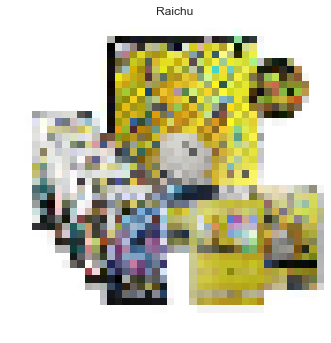

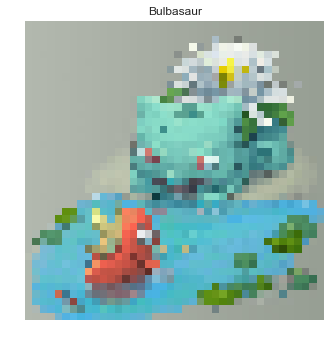

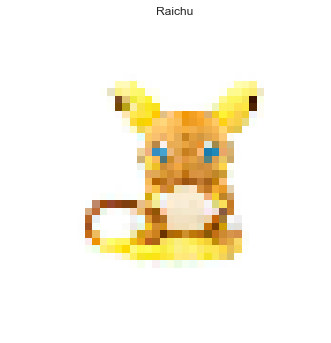

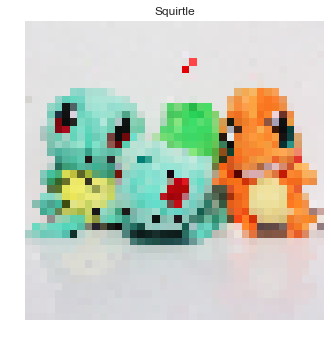

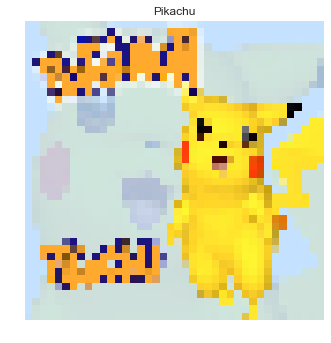

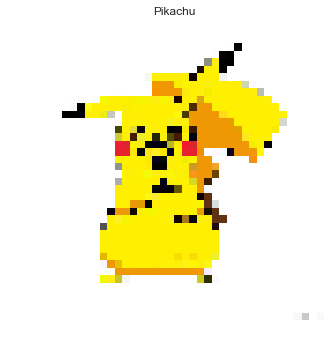

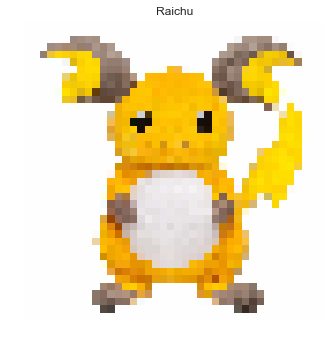

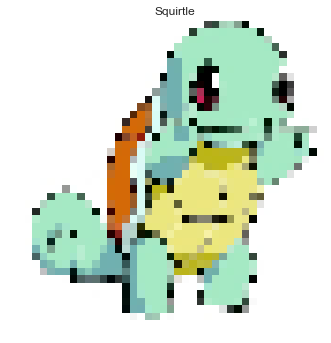

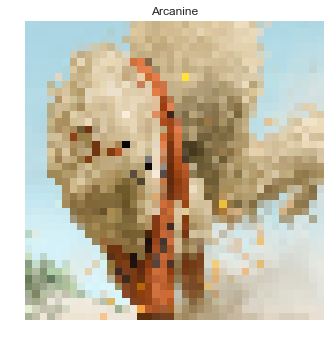

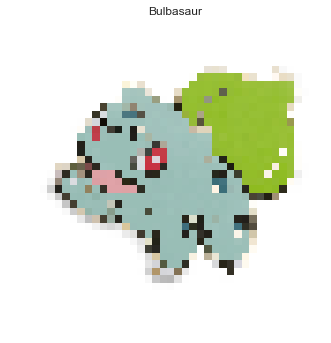

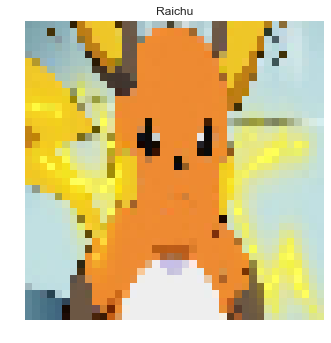

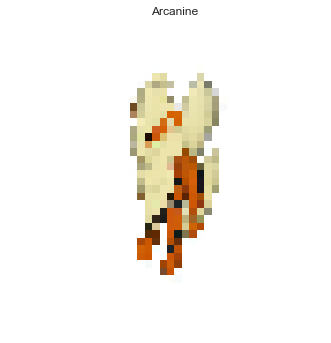

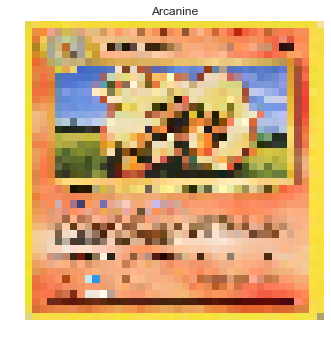

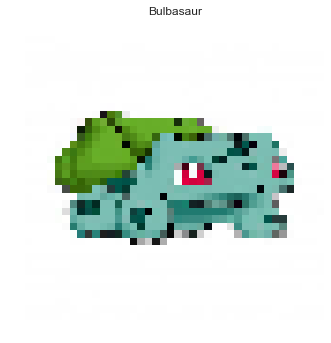

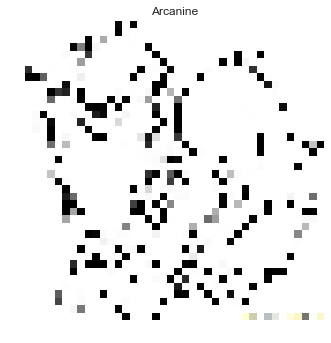

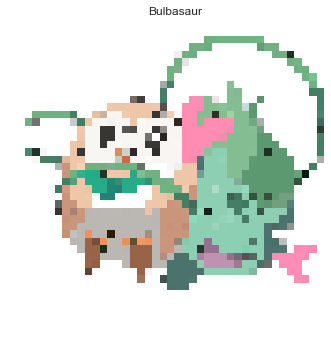

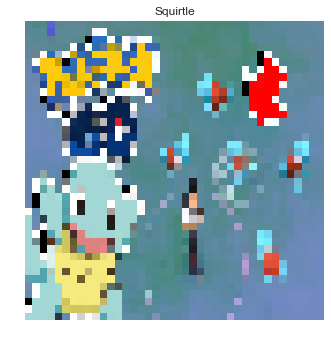

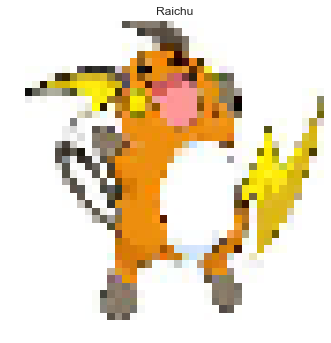

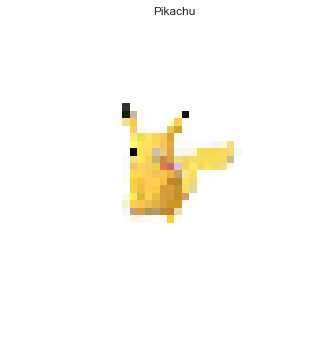

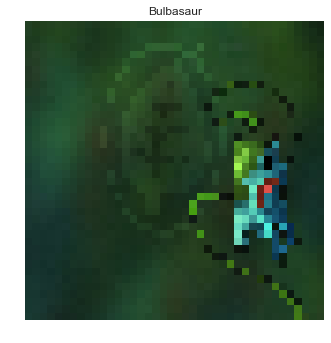

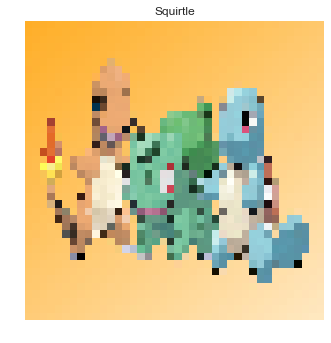

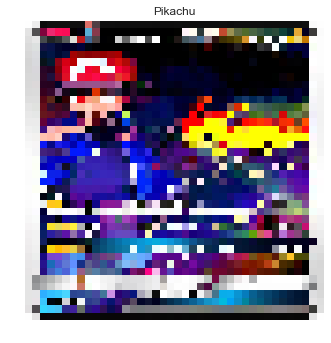

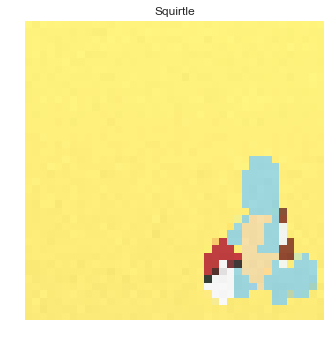

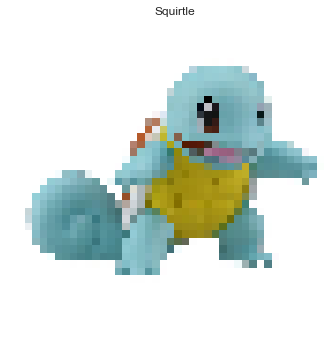

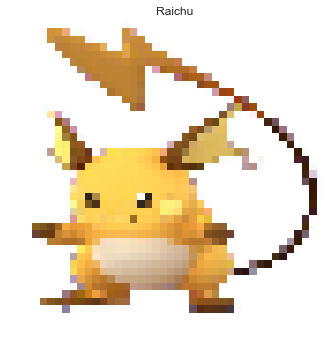

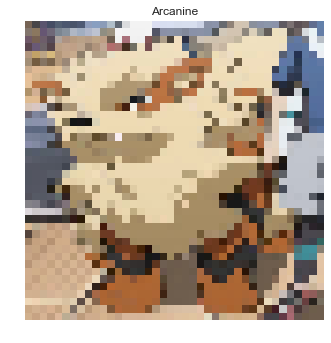

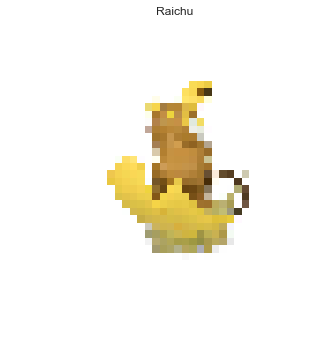

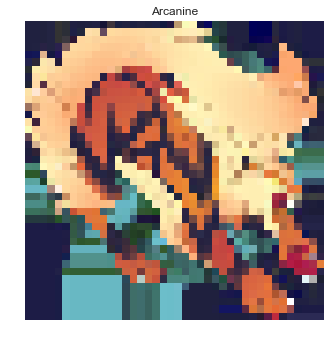

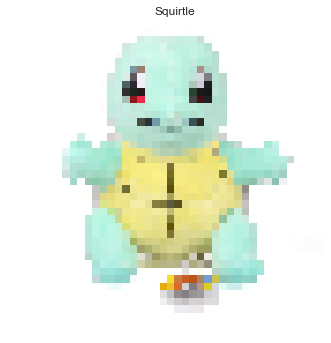

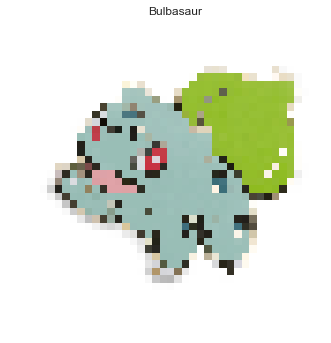

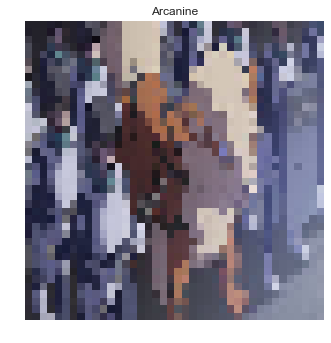

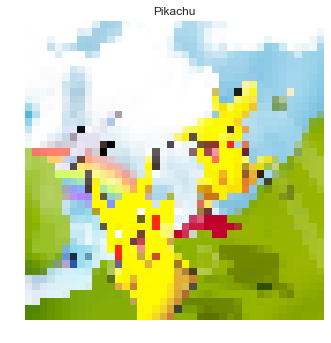

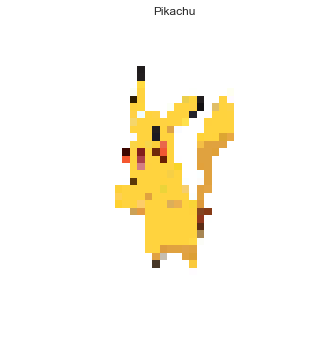

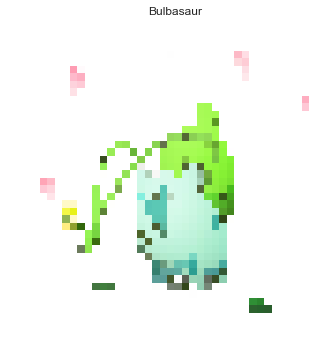

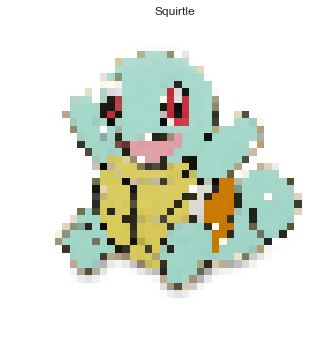

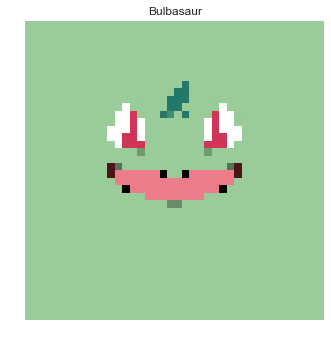

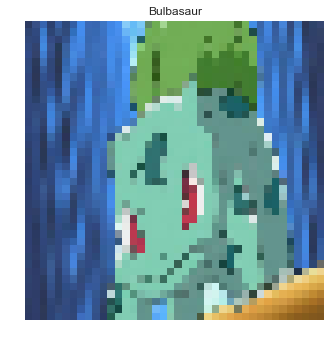

In [198]:
count=0
for i in range(outputs.shape[0]):
    if(outputs[i]!=y[i]):
        drawing(x[i].reshape(40,40,3),y[i])
        count+=1